In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def GetTestPicture(numbero_uno):
    global myNormal, myPhoto, myVector, myAlbedo, myMask
    myNormal = np.load('BigData\TestBigPastelNormals.npy')[numbero_uno]
    myPhoto = np.load('BigData\TestBigPastelPhotos.npy')[numbero_uno]
    myVector = np.load('BigData\TestBigPastelVectors.npy')[numbero_uno]
    myAlbedo = np.load('BigData\TestBigPastelAlbedos.npy')[numbero_uno]
    myMask = np.load('BigData\TestBigPastelMasks.npy')[numbero_uno]

In [3]:
def calculate_normal(points):
    v1 = points[1] - points[0]
    v2 = points[2] - points[0]
    normal = np.cross(v1, v2)
    return normal / np.linalg.norm(normal)

def calculate_lighting(normal, light_direction):
    light_direction = light_direction / np.linalg.norm(light_direction)
    intensity = np.dot(normal, light_direction)
    return max(intensity, 0)  

In [4]:
def UpdateLightMap():
    global lightmap
    light_dir = myVector
    lightmap = np.zeros((64,64,3))
    for x in range(64):
      for y in range(64):
          one_normal = myNormal[x,y]
          intense = calculate_lighting(one_normal, light_dir)
          lightmap[x,y] = np.array([1,1,1]) * intense


In [5]:
# Обратный процесс можно использовать чтобы получить из освещенного изображения диффузное изображение. 
# Это означает что: В целом нужна только модель нормалей
# Предсказав нормали я могу сначала убрать освещение с картинки, а затем добавить его используя один и тот же механизм
# В этой системе есть проблема: она считает что освещение точечное
# Картинки получены с учетом шарообразного источника света
# Поэтому даже тут они не совсем совпадают

In [6]:
#CONVINIENT TEST:

In [7]:
numbero_uno = 1

GetTestPicture(numbero_uno)
UpdateLightMap()

In [8]:
print(myVector)

[-0.354 -0.707  0.612]


[-0.354 -0.707  0.612]


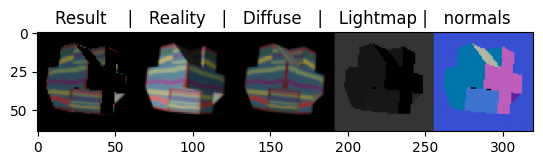

In [12]:
light_intensity = 4
ratio = 1
newThing = myAlbedo * lightmap * light_intensity
newThing = newThing  * ratio + lightmap * (1 - ratio)
newThing = (newThing / np.max( newThing)) * myMask
plt.title("Result    |   Reality   |   Diffuse   |   Lightmap |   normals ")
plt.imshow(np.concatenate([newThing, myPhoto, myAlbedo, lightmap, myNormal], axis = 1))
print(myVector)

C:\Users\Tomil\AppData\Local\Temp\ipykernel_12372\1147676661.py:4: RuntimeWarning: divide by zero encountered in divide
  zeroed = myPhoto / lightmap / light_intensity


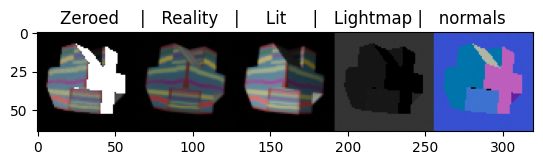

In [13]:
light_intensity = 10
ratio = 0.5

zeroed = myPhoto / lightmap / light_intensity
zeroed = zeroed * myMask
plt.title("Zeroed    |   Reality   |     Lit     |   Lightmap |   normals ")
plt.imshow(np.clip( np.concatenate([zeroed, myAlbedo, myPhoto, lightmap, myNormal], axis = 1), 0, 1))